## Habitable Exoplanets Binary classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from imblearn.over_sampling import SMOTE
from matplotlib import style
import pickle
style.use('ggplot')

In [2]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv(r'E:\MSC BDA SEM 2\ML Project\Created dataset with habitable\data_final.csv')

In [4]:
# Dropped due to many null values, all unique values more than 50%
drp_cols = ['pl_orbsmax','pl_orbeccen','pl_orbincl','pl_bmassj','pl_dens','ra_str','dec_str','ra','dec','st_dens','rowupdate']
df.drop(drp_cols,axis=1,inplace=True)

In [5]:
columns = df.columns.tolist()
categorical = [feature for feature in columns if df[feature].dtypes == 'O']
numerical = [feature for feature in columns if feature not in categorical]

In [6]:
count_class_0, count_class_1 = df['habitable'].value_counts()
df_1 = df[df['habitable']==1]
df_0 = df[df['habitable']==0]
df_0_under = df_0.sample(int(count_class_0*0.015), replace=True,random_state=100)
df_1_under = df_1.sample(int(count_class_1*0.5), replace=True,random_state=100)

df_html = pd.concat([df_1_under, df_0_under], axis=0)
df_html = df_html.sample(frac=1).reset_index()
df_html.drop(['st_mass', 'index'],axis=1,inplace=True)

In [7]:
df_html = df_html.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)

In [8]:
df_html.to_html('E:\\html\\table_sample_1.html')

In [9]:
# Methods used to discover exoplanets
df['pl_discmethod'].value_counts()

Transit                          3170
Radial Velocity                   804
Microlensing                       95
Imaging                            49
Transit Timing Variations          20
Eclipse Timing Variations          16
Pulsar Timing                       7
Orbital Brightness Modulation       6
Pulsation Timing Variations         2
Astrometry                          1
Disk Kinematics                     1
Name: pl_discmethod, dtype: int64

Most of the exoplanets are discovered using the Transit and Radial Velocity method

0    0.987053
1    0.012947
Name: habitable, dtype: float64


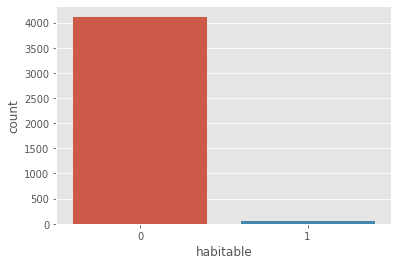

In [10]:
# Number of Habitable/Non Habitable Exoplanets
print(df['habitable'].value_counts()/len(df['habitable']))
sns.countplot(df['habitable'])

It's a highly imbalanced dataset with only 1.2% accounting to the Habitable class

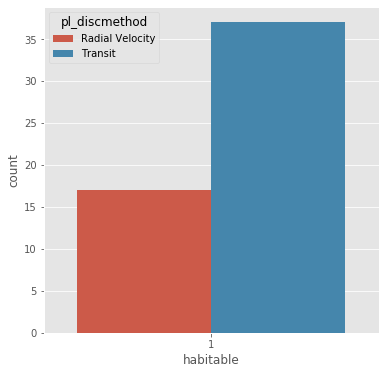

In [11]:
# Discovery Method of Exoplanets
df10 = df[df['habitable'] == 1]
plt.figure(figsize=(6,6))
sns.countplot(df10['habitable'],hue=df10['pl_discmethod'])

Habitable Exoplanets have been so far discovered by using only Transit and Radial Veloity techniques.

### Define Constants 

In [12]:
R0 = 6.9364*(10**8) ## Radius of Sun (m)
L0 = 3.828*(10**26) ## Luminosity of Sun (w/m2)
sigma = 5.67*(10**(-8)) ## Stefan Boltzman Constant
pi = np.pi
s1 = 1.1 ## Appropriate Solar Flux for inner boundary
s2 = 0.53 ## Appropriate Solar Flux for outer boundary 

### Compute Stellar Luminosity using Stellar Radius and Stellar Temperature 

In [13]:
st_rad = df['st_rad']*R0
lum = 4*pi*sigma*(st_rad.loc[:]**2)*(df['st_teff']**4)
app_mag = lum.loc[:]/L0
df['st_lum'] = app_mag

### Compute Inner and Outer Habitable zones 

In [14]:
# Inner Zone
df['Inner_radius'] = np.sqrt(df['st_lum'].loc[:]/1.1)

# Outer Zpne
df['Outer_radius'] = np.sqrt(df['st_lum']/0.53)

### Bin Stellar Class as Spectral Type (O, B,  A, F, G, K, M, C) 

In [15]:
# Stellar Class
bins = [574,3500,5000,6000,7500,10000,25000,59000]
labels = [1,2,3,4,5,6,7]
df['st_class'] = pd.cut(df['st_teff'],bins = bins, labels = labels)

In [16]:
# Add Created features to numerical and categorical lists
new_feat_num = ['Inner_radius', 'Outer_radius']
numerical += new_feat_num
categorical.append('st_class')

### Determine Transformation that gives Skewness, Kurtosis ~ 0

In [17]:
# Determine the skewness and kurtoisis of the following column
# LOG, LOG(1+VAL), SQUARE, INVERSE

def skew_kurt(column):
    
    funcs = {'orignal':column, 'log' : np.log(column), 'log1p':np.log1p(column), 'squr':column**2, 'inverse':1/column}
    for key,values in funcs.items():
        plt.figure(figsize = (15,6))
        print(" Transformation :",key,'\n',"Skewness : ",values.skew(),"   Kurtoisis : ",values.kurt())
        
        plt.subplot(1,2,1)
        sns.distplot(values)
        
        plt.subplot(1,2,2)
        sns.boxplot(values)
        plt.show()  

 Transformation : orignal 
 Skewness :  63.49470602399394    Kurtoisis :  4034.6408701112973


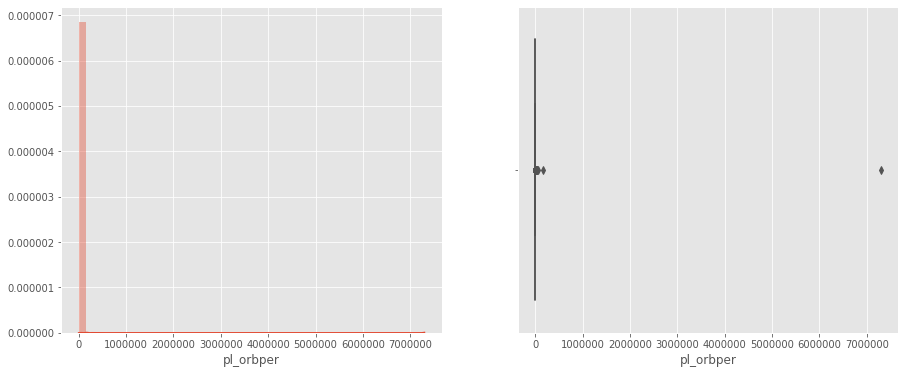

 Transformation : log 
 Skewness :  1.0928499367635969    Kurtoisis :  1.175999704910307


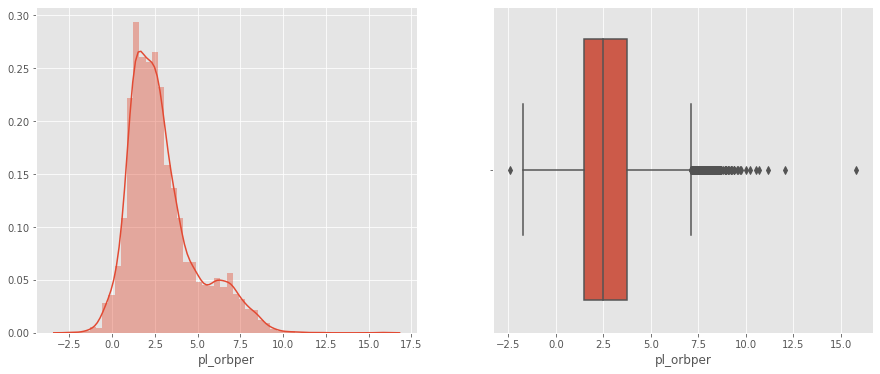

 Transformation : log1p 
 Skewness :  1.3115986721092412    Kurtoisis :  1.575549987654263


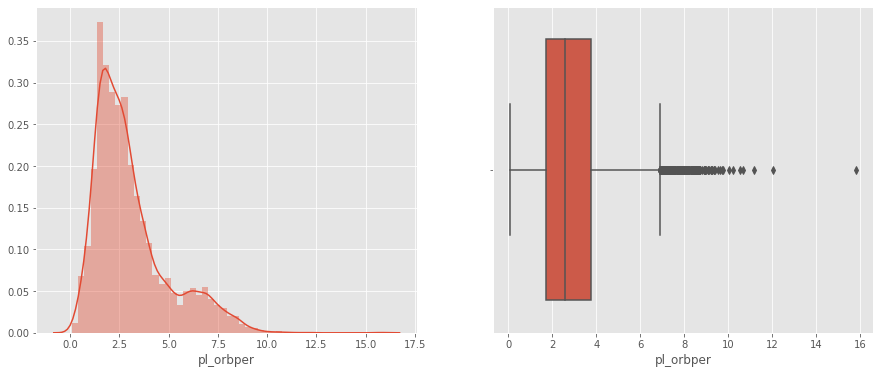

 Transformation : squr 
 Skewness :  63.56883127607026    Kurtoisis :  4040.997538397408


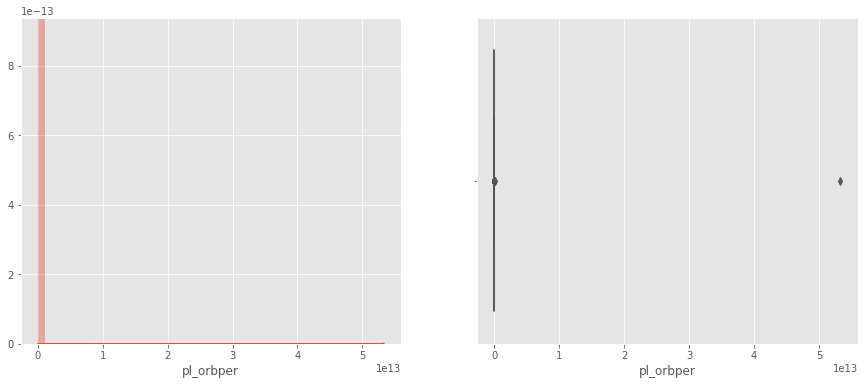

 Transformation : inverse 
 Skewness :  11.708285967564866    Kurtoisis :  277.44469662704495


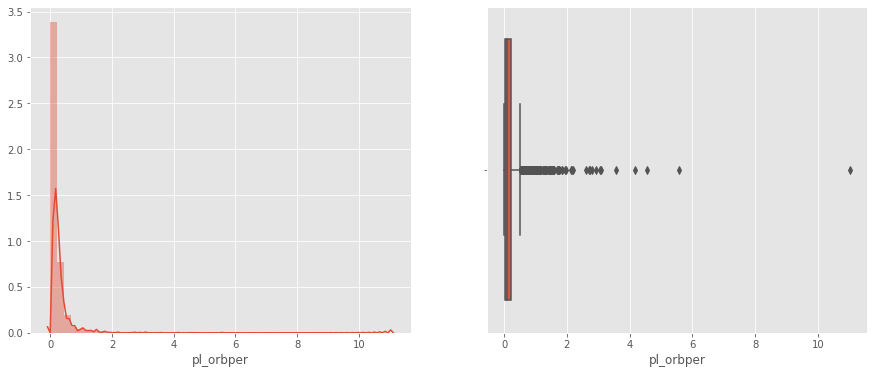

In [18]:
skew_kurt(df['pl_orbper']) ## LOG TRANSFORMATION GAVE BEST

 Transformation : orignal 
 Skewness :  2.804702369453897    Kurtoisis :  19.01923761623994


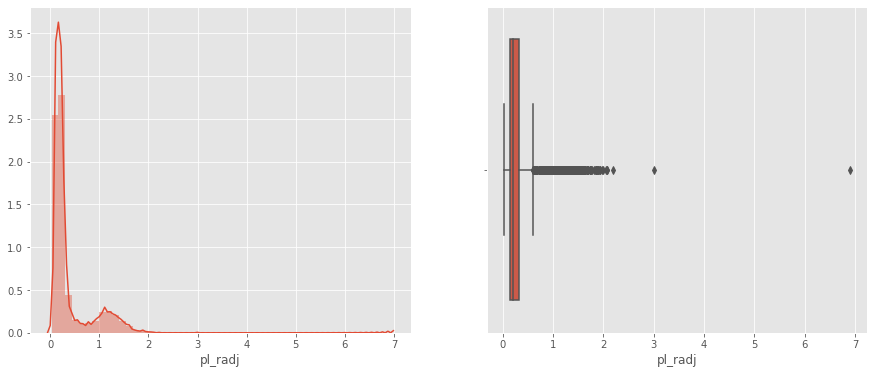

 Transformation : log 
 Skewness :  0.8521455797928934    Kurtoisis :  -0.10273282170297371


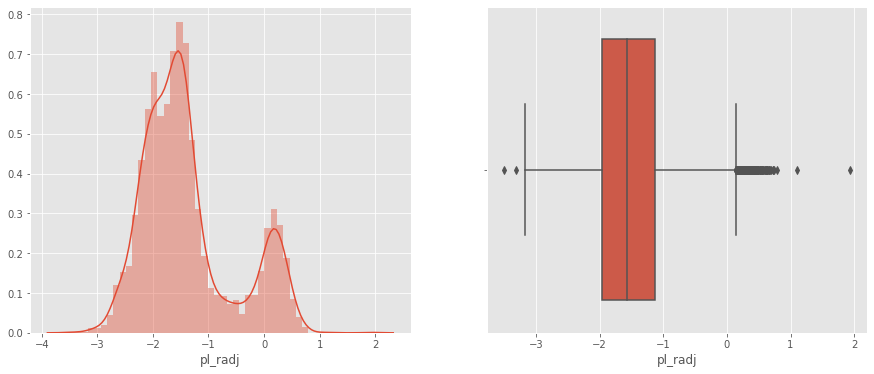

 Transformation : log1p 
 Skewness :  1.6680312103451338    Kurtoisis :  1.9714429942435916


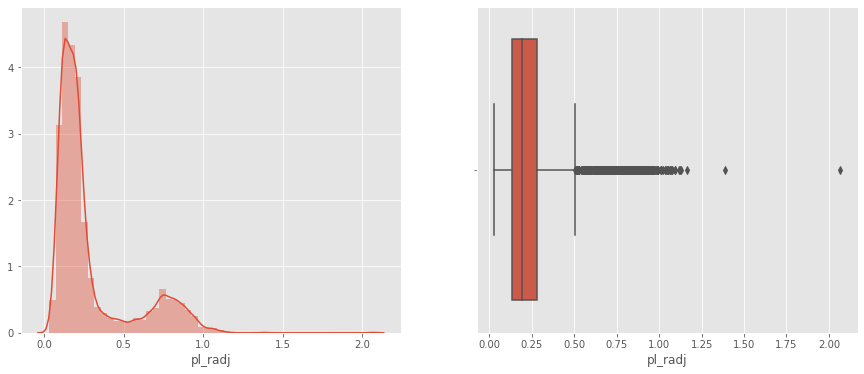

 Transformation : squr 
 Skewness :  28.304187010938975    Kurtoisis :  1226.8117415372187


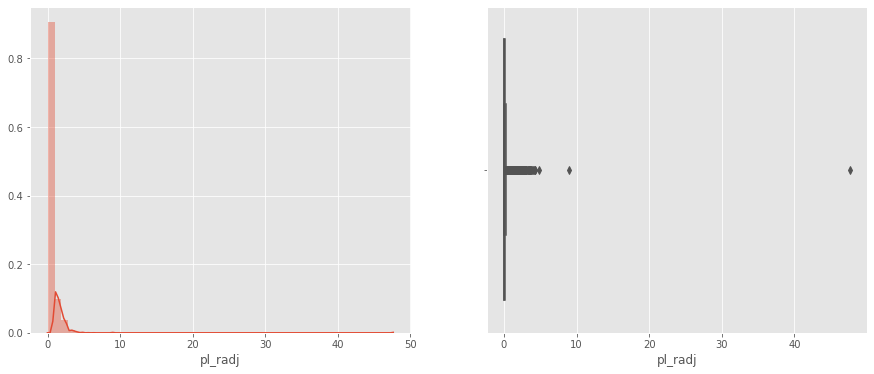

 Transformation : inverse 
 Skewness :  1.1463789058171205    Kurtoisis :  3.3793201623558846


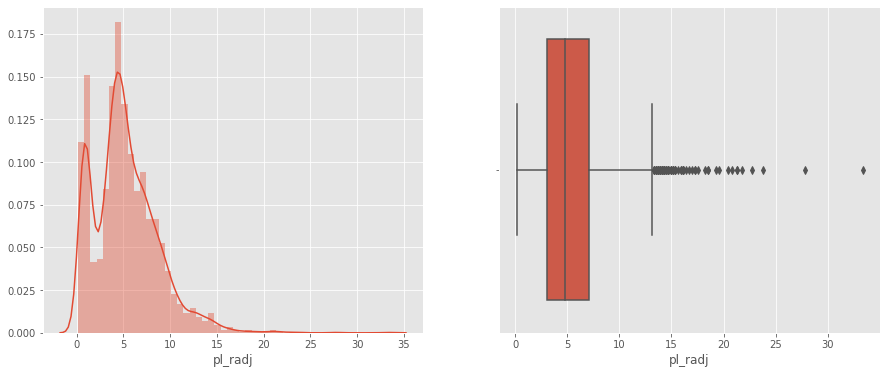

In [19]:
skew_kurt(df['pl_radj']) ## LOG TRANSFORMATION GAVE BEST

 Transformation : orignal 
 Skewness :  4.9725600886399794    Kurtoisis :  32.653527776874675


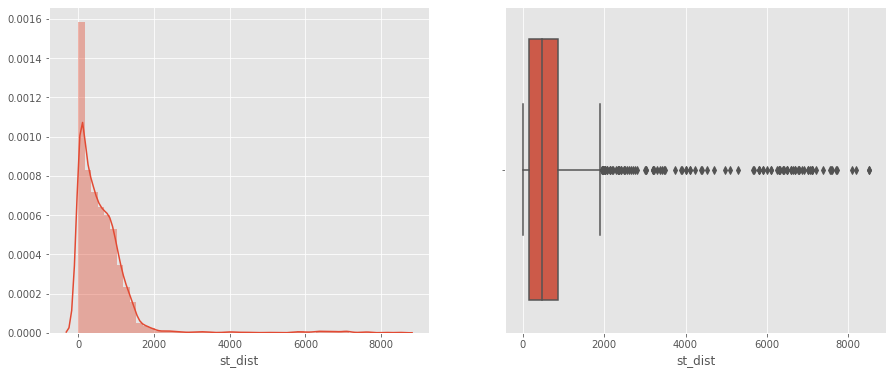

 Transformation : log 
 Skewness :  -0.8770715799878778    Kurtoisis :  0.4783141662457533


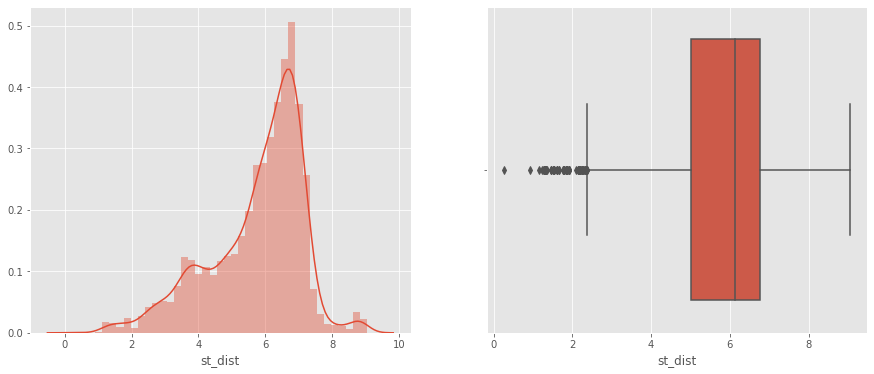

 Transformation : log1p 
 Skewness :  -0.8309432525428535    Kurtoisis :  0.3322364487285636


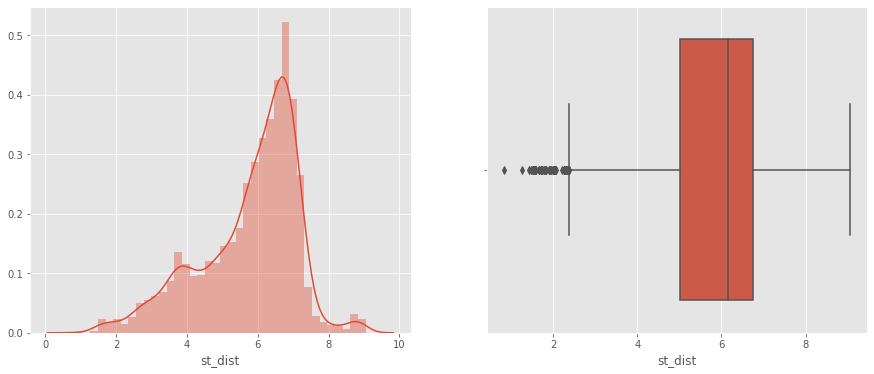

 Transformation : squr 
 Skewness :  8.730924703100753    Kurtoisis :  81.68418736311347


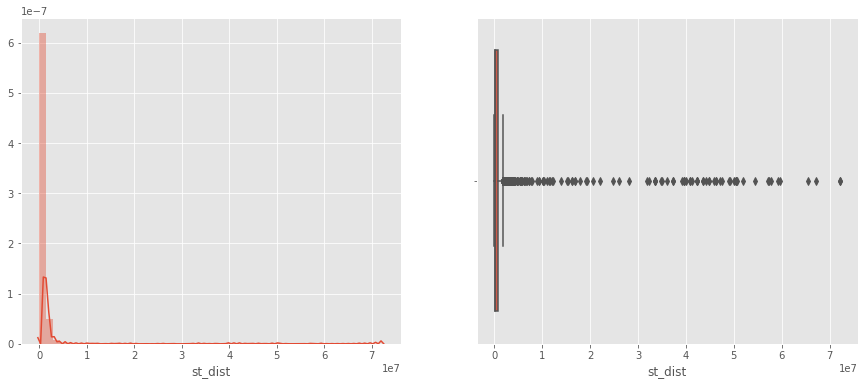

 Transformation : inverse 
 Skewness :  8.02732843649615    Kurtoisis :  107.34280484541186


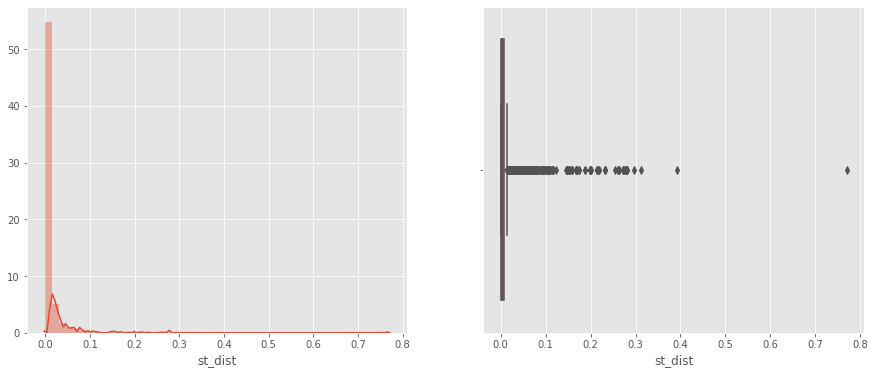

In [20]:
skew_kurt(df['st_dist']) ## LOG1P TRANSFORMATION GAVE BEST

 Transformation : orignal 
 Skewness :  9.018809814805914    Kurtoisis :  152.5794191015528


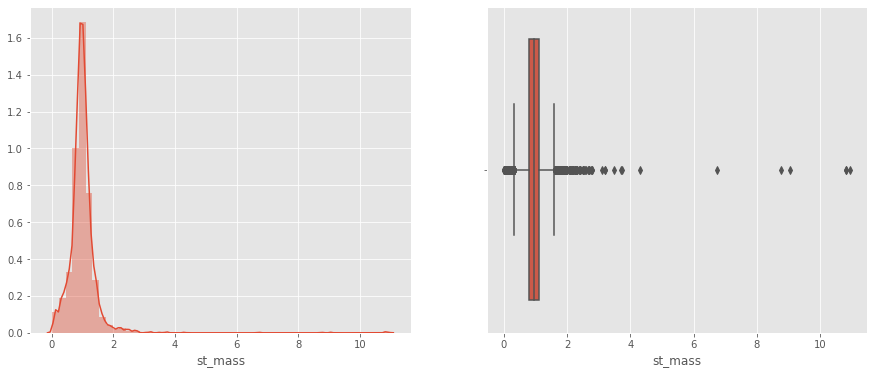

 Transformation : log 
 Skewness :  -2.456246188177352    Kurtoisis :  13.514396365871086


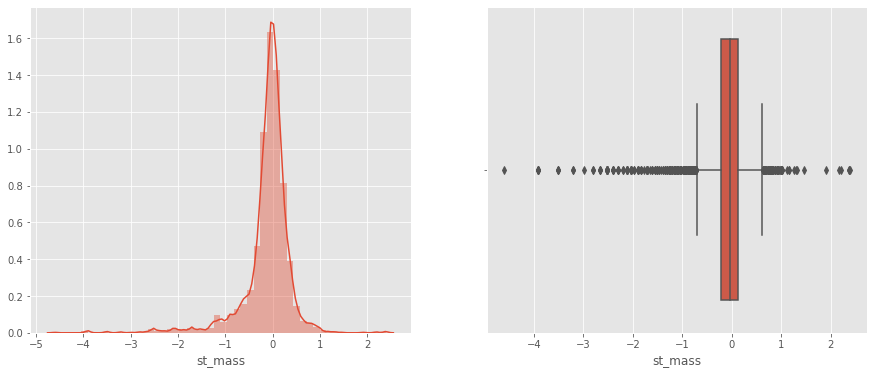

 Transformation : log1p 
 Skewness :  0.8805244846978802    Kurtoisis :  11.128129105638175


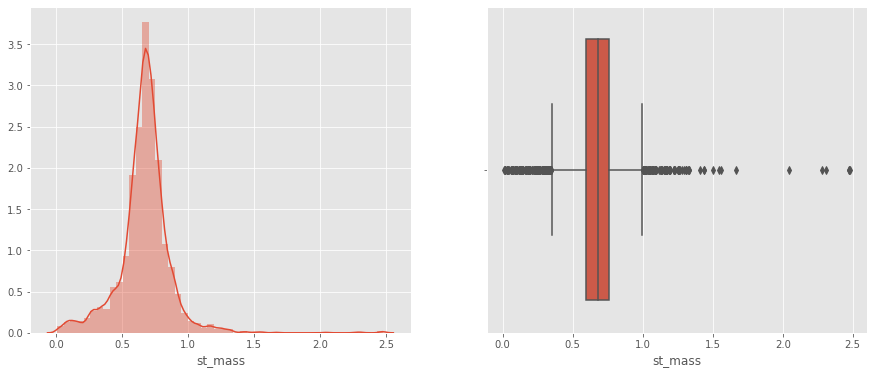

 Transformation : squr 
 Skewness :  24.15066164434423    Kurtoisis :  634.2378795649441


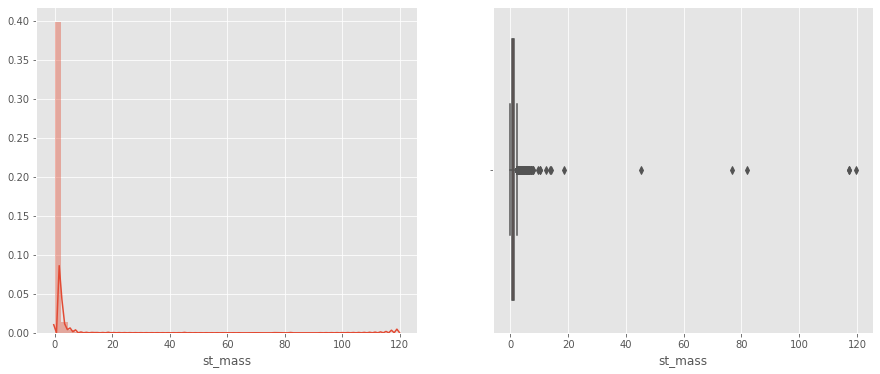

 Transformation : inverse 
 Skewness :  17.925381480405587    Kurtoisis :  437.03438627119687


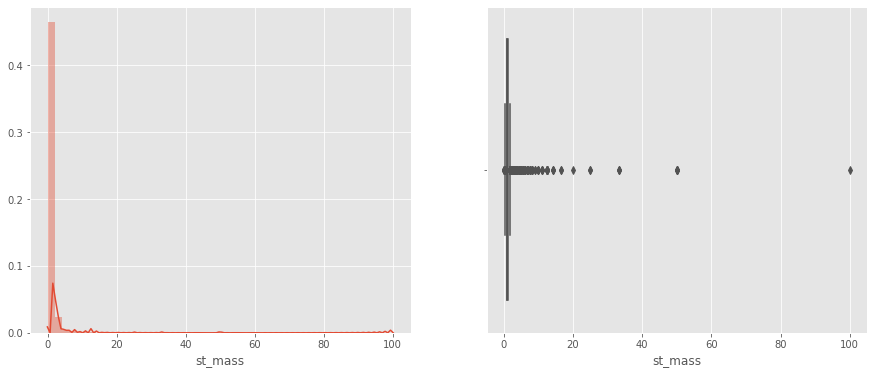

In [21]:
skew_kurt(df['st_mass']) ## LOG1P TRANSFORMATION GAVE BEST

 Transformation : orignal 
 Skewness :  12.18073870031629    Kurtoisis :  183.18269841319182


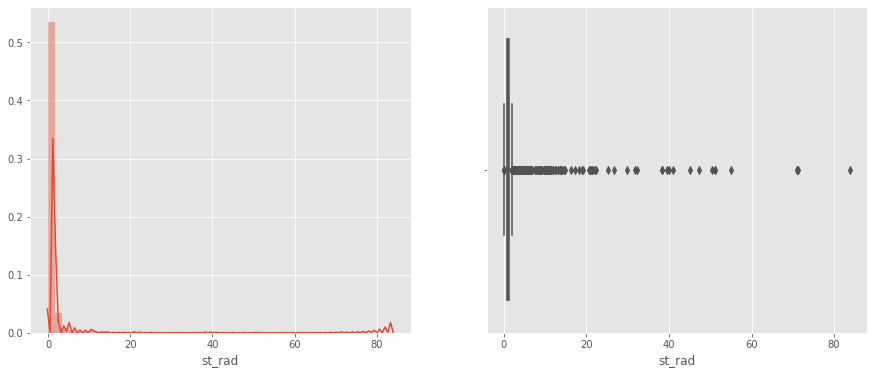

 Transformation : log 
 Skewness :  1.806132669233372    Kurtoisis :  10.434783203403214


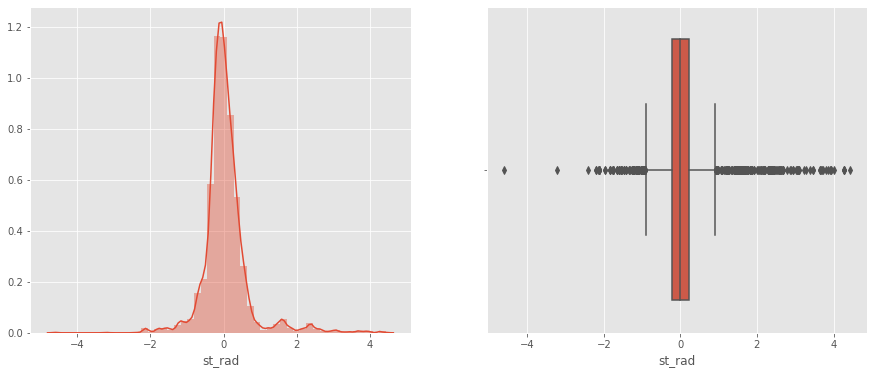

 Transformation : log1p 
 Skewness :  4.060903795791994    Kurtoisis :  22.558796137603018


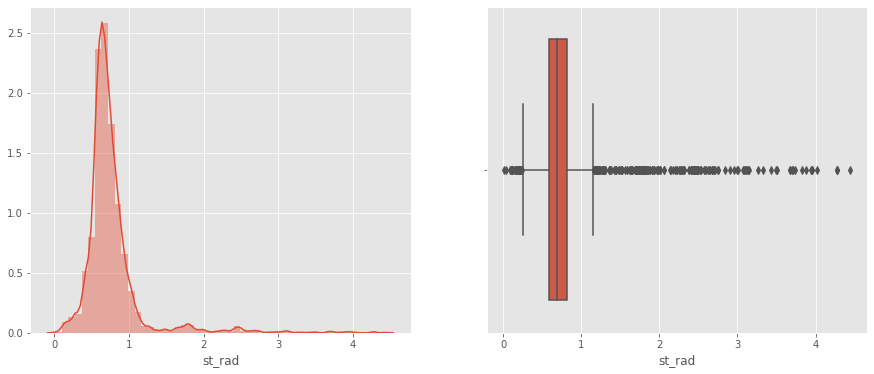

 Transformation : squr 
 Skewness :  21.250837636342705    Kurtoisis :  527.6085953276034


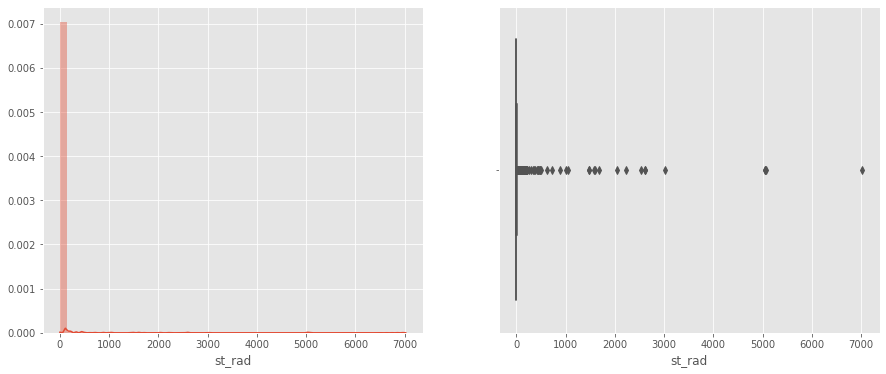

 Transformation : inverse 
 Skewness :  43.31169637962043    Kurtoisis :  2310.0860233764124


In [ ]:
skew_kurt(df['st_rad']) ## LOG TRANSFORMATION GAVE BEST

In [ ]:
skew_kurt(df['st_lum']) ## LOG TRANSFORMATION GAVE BEST

In [ ]:
skew_kurt(df['Inner_radius']) ## LOG TRANSFORMATION GAVE BEST

In [ ]:
skew_kurt(df['Outer_radius']) ## LOG TRANSFORMATION GAVE BEST

In [ ]:
## Perform Transformation

log = ['pl_orbper','pl_radj','st_teff','st_rad','st_lum']
log1p = ['st_dist','st_mass','Inner_radius','Outer_radius']
for feature in log:
    df[feature] = np.log(df[feature])
for feature in log1p:
    df[feature] = np.log1p(df[feature])

### Determine Outliers 

In [ ]:
def outlier(df,column):
    Q1 = df[column].quantile(0.25)
    Q2 = df[column].quantile(0.75)
    IQR = Q2-Q1
    low_lim = Q1 - 1.5*IQR
    upp_lim = Q2 + 1.5*IQR
    
    out_indices = df[(df[column] < low_lim)|(df[column] > upp_lim)].index.tolist()
    return out_indices

In [ ]:
orb_per = outlier(df,'pl_orbper')
pl_rad = outlier(df,'pl_radj')
st_teff = outlier(df,'st_teff')
st_rad = outlier(df,'st_rad')
st_lum = outlier(df,'st_lum')
st_dist = outlier(df,'st_dist')
st_mass = outlier(df,'st_mass')

In [ ]:
outlier_indices = orb_per+pl_rad+st_teff+st_rad+st_lum+st_dist+st_mass

In [ ]:
set_outlier_indices = set(outlier_indices)

In [ ]:
# Comparison with actual planets

with open(r'E:\MSC BDA SEM 2\ML Project\hab_planets_cnf.txt', 'r') as f:
    hab_actual = [line.strip() for line in f]

pl_name = df["pl_name"].tolist()
p2 = list(set(hab_actual).intersection(set(pl_name)))

In [ ]:
name = []
index = []
for i in range (len(hab_actual)):
    for j in range (len(pl_name)):
        if(pl_name[j] == hab_actual[i]):
            name.append(pl_name[j])
            index.append(j)
        else:
            pass

Since the Habitable class contributes to only 1.2% of total, ignore outliers for these classes 

In [ ]:
outlier_excluding = [i for i in set_outlier_indices if i not in index]

### Drop OUTLIER ROWS  

In [ ]:
df.drop(outlier_excluding,axis=0,inplace=True)

In [ ]:
# Missing Values
print('Percentage of missing values','\n')
for feature in columns:
    print(feature," : ",(df[feature].isna().sum()/len(df[feature])*100))

In [ ]:
## Indices of Null values

orb_per_null = df[df['pl_orbper'].isna()].index.tolist()
pl_rad_null = df[df['pl_radj'].isna()].index.tolist()
st_teff_null = df[df['st_teff'].isna()].index.tolist()
st_rad_null = df[df['st_rad'].isna()].index.tolist()
st_lum_null = df[df['st_lum'].isna()].index.tolist()
st_dist_null = df[df['st_dist'].isna()].index.tolist()
st_mass_null = df[df['st_mass'].isna()].index.tolist()

In [ ]:
null_indices = orb_per_null+pl_rad_null+st_teff_null+st_rad_null+st_lum_null+st_dist_null+st_mass_null
set_null_indices = set(null_indices)
null_indices_excluding = [x for x in set_null_indices if x not in index]

### Drop Nan Rows  

In [ ]:
df.drop(null_indices_excluding,axis=0,inplace=True)

In [ ]:
# Fill Remaining Rows with mean
columns = df.columns.tolist()
null_vals = [feature for feature in columns if df[feature].isna().sum() > 0 and feature != 'st_class']

for feature in null_vals:
    df[feature].fillna(df[feature].mean(),inplace=True)

In [ ]:
# Fill st_class missing value with mode
df['st_class'].fillna(df['st_class'].mode()[0],inplace=True)

### QQPlot and Boxplot to check Normality and Distribution

In [ ]:
for feature in numerical:
    plt.figure(figsize = (15,6))
    plt.subplot(1,2,1)
    stats.probplot(df[feature],dist="norm",plot=plt)
    plt.subplot(1,2,2)
    sns.boxplot(df[feature])
    plt.show()

### After Cleaning the missing values and outliers the count of target lable 'habitable' : 

In [ ]:
df['habitable'].value_counts()

### Corelation b/w input and target 

In [ ]:
df.corr().loc['habitable'].sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(4,10))
sns.heatmap(df.corr()[['habitable']].sort_values(by=['habitable'],ascending=False),cmap='coolwarm',annot=True,)

In [ ]:
# pl_hostname, pl_name donot impact the target
x = df.drop(['pl_hostname', 'pl_name','habitable','st_mass'],axis=1)
y = df['habitable']

In [ ]:
# Onehot Encoding for pl_discmethod
x1 = x.copy()
disc_method = pd.get_dummies(x1['pl_discmethod'],drop_first=True)
x1['pl_discmethod'] = disc_method
x1['st_class'] = x1['st_class'].astype(int)

### Up Sampling Using SMOTE

In [ ]:
smote = SMOTE()
x1, y1 = smote.fit_sample(x1, y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

### XGBClassifier 

In [ ]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)


params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=3, scoring='roc_auc', n_jobs=-1, cv=4, random_state=1001)



In [ ]:
random_search.fit(x_train,y_train)

In [ ]:
random_search.best_estimator_

In [ ]:
random_search.best_params_

In [ ]:
pred_xgb = random_search.predict(x_test)

In [ ]:
print(classification_report(y_test,pred_xgb))

In [ ]:
pickle.dump(random_search, open('model.pkl','wb'))

In [ ]:
model = pickle.load(open('model.pkl','rb'))